## Imports

In [1]:
import math

import numpy as np
from pycircstat.tests import rayleigh
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

from sherlock_helpers.constants import DATA_DIR, FIG_DIR, GRID_SCALE
from sherlock_helpers.functions import add_arrows, show_source

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Set plotting params

In [2]:
STEP = 1.2
THRESH = 0.05
cmap = plt.cm.Spectral
mpl.rcParams['pdf.fonttype'] = 42

## Load data

In [3]:
avg_recall_events = np.load(DATA_DIR.joinpath('avg_recall_events.npy'))
mappings = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)
embeddings = np.load(DATA_DIR.joinpath('embeddings.npy'), allow_pickle=True)
episode_embedding, avg_recall_embedding, recall_embeddings = embeddings

## Define/inspect some functions/classes

In [4]:
show_source(add_arrows)

In [5]:
class Point:
    def __init__(self, coord=None):
        self.coord = np.array(coord)

In [6]:
class LineSegment:  
    def __init__(self, p1=None, p2=None):
        if not isinstance(p1, Point):
            p1 = Point(p1)
        if not isinstance(p2, Point):
            p2 = Point(p2)
        
        self.p1 = p1
        self.p2 = p2
        self.vec = self.p2.coord - self.p1.coord
        
    @property
    def norm(self):
        diff = self.get_p2() - self.get_p1()
        return diff / np.linalg.norm(diff)
    
    @property
    def angle(self):
        p1 = np.zeros_like(self.get_p1())
        p2 = np.zeros_like(self.get_p1())
        p2[0] = 1
        ref = LineSegment(p1, p2)
        return self.angle_with(ref)
    
    def get_p1(self):
        return self.p1.coord
    
    def get_p2(self):
        return self.p2.coord
        
    def intersects(self, z):
        if isinstance(z, Circle):
            return _seg_intersect_circle(self, z)
        elif isinstance(x, Rectangle):
            return _seg_intersect_rect(self, z)
        
    def angle_with(self, ref):
        assert isinstance(ref, LineSegment)
        v0 = ref.vec
        v1 = self.vec
        angle = np.arccos(v0.dot(v1) / (np.linalg.norm(v0) * np.linalg.norm(v1)))
        if self.vec[1] < 0:
            angle = (2 * np.pi) - angle
            
        return angle

In [7]:
class Circle:
    def __init__(self, center=None, r=None):
        self.center = np.array(center)
        self.r = r 
    
    def get_center(self):
        return self.center
    
    def get_radius(self):
        return self.r

In [8]:
def _seg_intersect_circle(ls, circ):
    Q = circ.get_center()
    r = circ.get_radius()
    P1 = ls.get_p1()
    V = ls.get_p2() - P1
    
    a = V.dot(V)
    b = 2 * V.dot(P1 - Q)
    c = P1.dot(P1) + Q.dot(Q) - 2 * P1.dot(Q) - r ** 2
    
    disc = b ** 2 - 4 * a * c
    if disc < 0:
        return False
    
    sqrt_disc = math.sqrt(disc)
    t1 = (-b + sqrt_disc) / (2 * a)
    t2 = (-b - sqrt_disc) / (2 * a)
    if not (0 <= t1 <= 1 or 0 <= t2 <= 1):
        return False
    
    return True

In [9]:
def compute_coord(xi, yi, w, seglist, kind='rectangle'):
    if kind=='rectangle':
        z = Rectangle(x=xi, y=yi, w=w)
    elif kind=='circle':
        z = Circle(center=[xi,yi], r=w)
        
    segs = list(filter(lambda s: s.intersects(z), seglist))
    c = len(segs)
    if c > 1:
        u, v  = np.array([seg.norm for seg in segs]).mean(0)
        rads = np.array([seg.angle for seg in segs])
        p, z = rayleigh(rads)
    else:
        u = 0
        v = 0
        p = 1
    return u, v, p, c

In [10]:
def plot_embedding_flow(ax, cmap='Spectral', **kwargs):
    color = M.reshape(M.shape[0] * M.shape[1], 4)
    ax.quiver(X, Y, U, V, color=color, zorder=1, width=.004)
    ax.plot(avg_recall_embedding[:, 0], avg_recall_embedding[:, 1], zorder=2, c='k', alpha=.5)
    add_arrows(ax, 
               avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               zorder=3, 
               alpha=1, 
               color='k', 
               fill=True)
    ax.scatter(avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               c=range(avg_recall_embedding.shape[0]), 
               cmap=cmap, 
               s=150, 
               zorder=4)
    ax.scatter(avg_recall_embedding[:, 0], 
               avg_recall_embedding[:, 1], 
               c='k', 
               cmap=cmap, 
               s=200,
               zorder=3)
    ax.set_xlim(-20, 21)
    ax.set_ylim(-17, 23)
    ax.set_aspect('equal')
    ax.axis('off')

    return ax

In [11]:
def add_circle(xy, radius, ax, color='blue', alpha=0.5, linewidth=0, linestyle='solid', fill=True, **kwargs):
    circle = plt.Circle(xy, radius=radius, color=color, alpha=alpha, lw=linewidth, ls=linestyle, 
                        fill=fill, transform=ax.transData, zorder=4, **kwargs)
    ax.add_patch(circle)
    return ax

In [12]:
def plot_rayleigh(x_ix, y_ix, circle, ax, color='b', alpha=0.3, bin_degrees=20, **kwargs):
    segs = [s for s in seglist if s.intersects(circle)]
    if len(segs) > 0:        
        thetas = np.array([s.angle for s in segs])
        bins = np.deg2rad(np.arange(0, 360 + bin_degrees, bin_degrees))
        bincounts, *_ = ax.hist(thetas, bins=bins, color=color, alpha=alpha, **kwargs)

        u, v = np.mean([s.norm for s in segs], axis=0)
        arrow = LineSegment((0, 0), (u, v))
        arrow_len = np.linalg.norm(arrow.vec) * bincounts.max()
        angle_transform = mpl.transforms.Affine2D().translate(arrow.angle, 0) + ax.transData
        arrow_color = M[x_ix, y_ix]
        if not np.array_equal(arrow_color, np.array([0.5, 0.5, 0.5, 0.25])):
            arrow_color = mpl.colors.to_rgba(color, arrow_color[3])

        edgecolor = mpl.colors.to_rgba('k', arrow_color[3])
        ax.arrow(0, 0, 0, arrow_len, 
                 width=0.15, head_width=0.4, length_includes_head=True, 
                 facecolor=arrow_color, edgecolor=edgecolor, linewidth=1,
                 transform=angle_transform)
        ax.set_rlabel_position(0)
    return ax

In [13]:
def plot_flow_around(x_ix, 
                     y_ix,
                     colors='grey',
                     alpha=1,
                     bg_color='blue', 
                     bg_alpha=0.3,
                     plot_average=True,
                     arrows=False,
                     ax=None,
                     rayleigh_ax=None, 
                     flow_ax=None, 
                     circle_kwargs=None,
                     arrow_kwargs=None,
                     rayleigh_kwargs=None, 
                     flow_kwargs=None, 
                     **kwargs):
    if ax is None:
        ax = plt.gca()

    x = X[x_ix, y_ix]
    y = Y[x_ix, y_ix]
    radius = STEP * 2
    circle = Circle(center=(x, y), r=radius)
    if circle_kwargs is None:
        circle_kwargs = dict()
        
    clip_circle = plt.Circle(circle.center, 
                             radius=circle.r, 
                             color=bg_color, 
                             alpha=bg_alpha, 
                             fill=True, 
                             transform=ax.transData, 
                             **circle_kwargs)
    try:
        sns.color_palette(colors)
        c = 'k'
        is_palette = True
    except ValueError:
        c = colors
        is_palette = False
        
    if arrows and arrow_kwargs is None:
        arrow_kwargs = dict()
        
    intersect_counts = list()
    for sub_emb in recall_embeddings:
        sub_intersects = 0
        for i in range(len(sub_emb) - 1):
            seg = LineSegment(Point(sub_emb[i]), Point(sub_emb[i+1]))
            if seg.intersects(circle):
                ax.plot(sub_emb[i:i+2, 0], 
                        sub_emb[i:i+2, 1], 
                        c=c, 
                        alpha=alpha, 
                        clip_path=clip_circle, 
                        zorder=3,
                        **kwargs)
                if arrows:
                    add_arrows(ax, 
                               sub_emb[i:i+2, 0], 
                               sub_emb[i:i+2, 1], 
                               color=c, 
                               alpha=alpha, 
                               zorder=3,
                               **arrow_kwargs)
                sub_intersects += 1
                
        if sub_intersects > 0:
            intersect_counts.append(sub_intersects)
        
    if is_palette:
        lines = ax.get_lines()
        line_ix = 0
        palette = sns.color_palette(colors, len(intersect_counts))
        for n, c in zip(intersect_counts, palette):
            for _ in range(n):
                lines[line_ix].set_color(c)
                line_ix += 1
        
    if plot_average:
        ax.plot(avg_recall_embedding[:, 0],
                avg_recall_embedding[:, 1], 
                c='k', 
                linewidth=2, 
                clip_path=clip_circle, 
                zorder=2,
                **kwargs)
        if arrows:
            add_arrows(ax, 
                       avg_recall_embedding[:, 0],
                       avg_recall_embedding[:, 1], 
                       color='k', 
                       zorder=2,
                       **arrow_kwargs)
        
    if arrows:
        for a in ax.artists:
            a.set_clip_path(clip_circle)
            
    ax.add_patch(clip_circle)
    ax.set_xlim(x - radius, x + radius)
    ax.set_ylim(y - radius, y + radius)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if flow_ax is not None:
        if flow_kwargs is None:
            flow_kwargs = dict()
            
        add_circle((x, y), radius=radius, color=bg_color, ax=flow_ax, **flow_kwargs)
    
    if rayleigh_ax is not None:
        assert isinstance(rayleigh_ax.properties()['xaxis'], mpl.projections.polar.ThetaAxis)
        if rayleigh_kwargs is None:
            rayleigh_kwargs = dict()
            
        plot_rayleigh(x_ix, y_ix, circle, color=bg_color, ax=rayleigh_ax, **rayleigh_kwargs)
        
#     ############
#     print(ax.get_xlim(), ax.get_ylim())
#     print(clip_circle.center, clip_circle.radius)
#     print(ax.patches[0].center, ax.patches[0].radius)
#     print(flow_ax.patches[-1].center, flow_ax.patches[-1].radius)
#     print()
#     ############
    
    return ax

## Set up embedding components

In [14]:
# create 2D grid
X, Y = np.meshgrid(np.arange(-GRID_SCALE, GRID_SCALE, STEP), 
                   np.arange(-GRID_SCALE, GRID_SCALE, STEP))

# create list of line segments from individual recall embeddings
seglist = []
for sub in recall_embeddings:
    for i in range(sub.shape[0] - 1):
        p1 = Point(coord=sub[i, :])
        p2 = Point(coord=sub[i + 1, :])
        seg = LineSegment(p1=p1, p2=p2)
        seglist.append(seg)
        
# compute avg vector and p-value at each grid point
U = np.zeros_like(X)
V = np.zeros_like(X)
P = np.zeros_like(X)
Z = np.zeros_like(X)
C = np.zeros_like(X)

pbar = tqdm(total=len(X)**2, leave=False)
for i, (x, y) in enumerate(zip(X, Y)):
    for j, (xi, yi) in enumerate(zip(x, y)):
        U[i, j], V[i, j], P[i, j], C[i, j] = compute_coord(xi, yi, 
                                                           STEP * 2, 
                                                           seglist, 
                                                           kind='circle')
        pbar.update()
pbar.close()

Pc = multipletests(P.ravel(), method='fdr_bh', alpha=THRESH)[1].reshape(P.shape)
M = np.hypot(U, V)
M = plt.cm.Blues(M)
M[Pc > THRESH] = [.5, .5, .5, .25]
M[P == 1] = [.5, .5, .5, 0]

Widget Javascript not detected.  It may not be installed or enabled properly.


## Plot

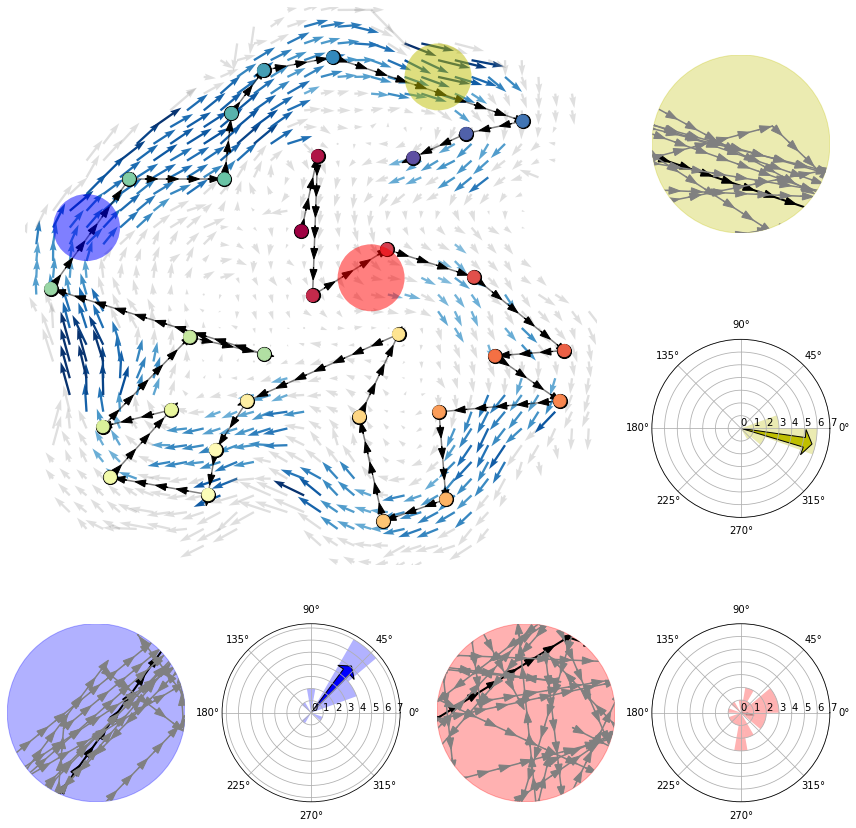

In [133]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(3, 4)
flow_ax = fig.add_subplot(gs[:-1, :-1])

zoom_ax1 = fig.add_subplot(gs[-1, 0])
polar_ax1 = fig.add_subplot(gs[-1, 1], polar=True)

zoom_ax2 = fig.add_subplot(gs[-1, 2])
polar_ax2 = fig.add_subplot(gs[-1, 3], polar=True)

zoom_ax3 = fig.add_subplot(gs[0, -1])
polar_ax3 = fig.add_subplot(gs[1, -1], polar=True)

arrow_kwargs = {
    'aspace': 0.6,
    'head_width': 0.2
}
rayleigh_kwargs = {'density': False}

plot_embedding_flow(flow_ax)
plot_flow_around(31, 12, bg_color='b', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax1, rayleigh_ax=polar_ax1, flow_ax=flow_ax, rayleigh_kwargs=rayleigh_kwargs)
plot_flow_around(28, 29, bg_color='r', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax2, rayleigh_ax=polar_ax2, flow_ax=flow_ax, rayleigh_kwargs=rayleigh_kwargs)
plot_flow_around(40, 33, bg_color='y', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax3, rayleigh_ax=polar_ax3, flow_ax=flow_ax, rayleigh_kwargs=rayleigh_kwargs)

polar_axes = (polar_ax1, polar_ax2, polar_ax3)
max_bincount = int(max([b.get_height() for ax in polar_axes for b in ax.patches]))
for ax in polar_axes:
#     ax.set_rlim(0, max_bincount)
    ax.set_rticks(list(range(max_bincount + 1)))

plt.tight_layout()
# plt.savefig(FIG_DIR.joinpath('topic_space_flow.pdf'))
plt.show()

In [58]:
a = polar_ax1.artists[0]

In [67]:
x = np.random.rand(25)

In [71]:
x, y = X[40, 33], Y[40, 33]
c = Circle((x, y), r=STEP*2)

In [74]:
segs = [s for s in seglist if s.intersects(c)]
thetas = [s.angle for s in segs]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(array([1.43239449, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.47746483, 0.95492966]),
 array([0.        , 0.34906585, 0.6981317 , 1.04719755, 1.3962634 ,
        1.74532925, 2.0943951 , 2.44346095, 2.7925268 , 3.14159265,
        3.4906585 , 3.83972435, 4.1887902 , 4.53785606, 4.88692191,
        5.23598776, 5.58505361, 5.93411946]),
 <a list of 17 Patch objects>)

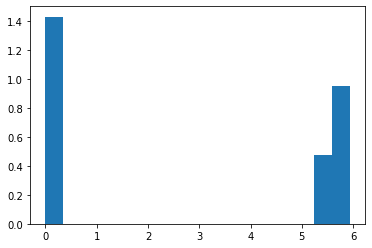

In [84]:
plt.hist(thetas, bins=np.arange(0, 2*np.pi, 2*np.pi*20/360), normed=True)

In [83]:
np.histogram(thetas, bins=np.arange(0, 2*np.pi, 2*np.pi*20/360))[0]

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2])

In [95]:
hist = np.histogram(thetas, bins=np.arange(0, 2*np.pi, 2*np.pi*20/360))[0]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

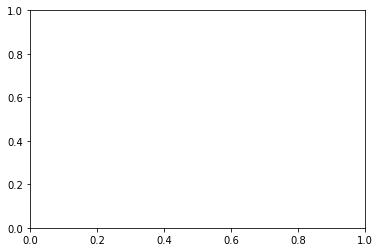

In [91]:
plt.bar(np.arange(0, 2*np.pi, 2*np.pi*20/360), bincounts / bincounts.sum())

In [94]:
np.arange(0, 2*np.pi, 2*np.pi*20/360)

array([0.        , 0.34906585, 0.6981317 , 1.04719755, 1.3962634 ,
       1.74532925, 2.0943951 , 2.44346095, 2.7925268 , 3.14159265,
       3.4906585 , 3.83972435, 4.1887902 , 4.53785606, 4.88692191,
       5.23598776, 5.58505361, 5.93411946])

In [130]:
bincounts, bins = np.histogram(thetas, bins=np.arange(0, 2*np.pi, 2*np.pi*20/360))
bin_xlocs = (np.convolve(bins, np.ones(2), mode='full') / 2)[1:-1]

<BarContainer object of 17 artists>

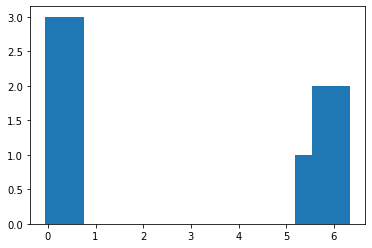

In [132]:
plt.bar(bins[1:], bincounts)

In [124]:
(np.convolve(bins, np.ones(2), mode='full') / 2)

array([0.        , 0.17453293, 0.52359878, 0.87266463, 1.22173048,
       1.57079633, 1.91986218, 2.26892803, 2.61799388, 2.96705973,
       3.31612558, 3.66519143, 4.01425728, 4.36332313, 4.71238898,
       5.06145483, 5.41052068, 5.75958653, 2.96705973])

In [127]:
bins

array([0.        , 0.34906585, 0.6981317 , 1.04719755, 1.3962634 ,
       1.74532925, 2.0943951 , 2.44346095, 2.7925268 , 3.14159265,
       3.4906585 , 3.83972435, 4.1887902 , 4.53785606, 4.88692191,
       5.23598776, 5.58505361, 5.93411946])

In [115]:
test = []
for i in range(len(bins) - 1):
    test.append((bins[i:i+2]).mean())
    
test = np.array(test)

True

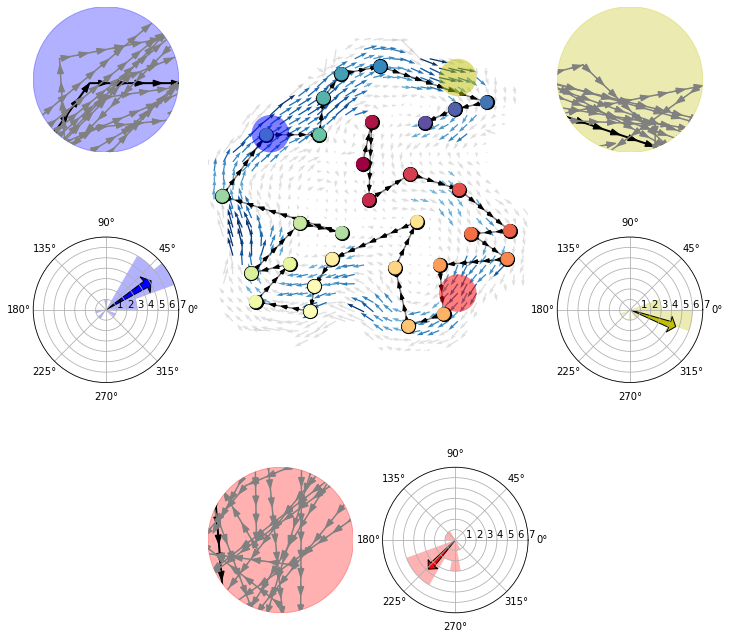

In [68]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(3, 4)
flow_ax = fig.add_subplot(gs[:-1, 1:-1])

zoom_ax1 = fig.add_subplot(gs[0, 0])
polar_ax1 = fig.add_subplot(gs[1, 0], polar=True)

zoom_ax2 = fig.add_subplot(gs[-1, 1])
polar_ax2 = fig.add_subplot(gs[-1, 2], polar=True)

zoom_ax3 = fig.add_subplot(gs[0, -1])
polar_ax3 = fig.add_subplot(gs[1, -1], polar=True)

arrow_kwargs = {
    'aspace': 0.6,
    'head_width': 0.2
}

plot_embedding_flow(flow_ax)
plot_flow_around(34, 15, bg_color='b', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax1, rayleigh_ax=polar_ax1, flow_ax=flow_ax)
plot_flow_around(17, 35, bg_color='r', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax2, rayleigh_ax=polar_ax2, flow_ax=flow_ax)
plot_flow_around(40, 35, bg_color='y', arrows=True, arrow_kwargs=arrow_kwargs, 
                 ax=zoom_ax3, rayleigh_ax=polar_ax3, flow_ax=flow_ax)

polar_axes = (polar_ax1, polar_ax2, polar_ax3)
max_bincount = max([b.get_height() for ax in polar_axes for b in ax.patches])
for ax in polar_axes:
    ax.set_rlim(0, max_bincount)

# plt.tight_layout()
plt.show()